In [1]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
import pymutspec

from Bio import SeqIO
from Bio.Data import CodonTable
from scipy import spatial

In [2]:
coda = CodonAnnotation(1)

In [34]:
ref = pd.read_csv('../data/reference_exp_muts.csv', index_col=0).drop(
    ['MutExp', 'IsStem', 'SsPairs', 'Quadr', 'Strand_Quadr', 'MutObsNC'], 
    axis=1,
)
ref['Mut'] = ref['NeighL'] + '[' + ref['RefNuc'] \
                + '>' + ref['AltNuc'] + ']' + ref['NeighR']
ref['RefCxt'] = ref['NeighL'] + ref['RefNuc'] + ref['NeighR']
ref['is_fourfold'] = ref['RefCodon'].apply(
    lambda x: coda.is_fourfold(
        x.replace('U', 'T')) if isinstance(x, str) else False)
ref

/tmp/ipykernel_24226/4093717136.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  ref = pd.read_csv('../data/reference_exp_muts.csv', index_col=0).drop(


,Pos,RefNuc,GenName,GenType,CodonNumber,RefCodon,RefAa,NucInCodon,AltNuc,AltCodon,AltAa,AaSub,NeighL,NeighR,Mut,RefCxt,is_fourfold
1,1,A,5UTR,untranslated,NaN,NaN,NaN,None,U,NaN,NaN,NaN,NaN,U,NaN,NaN,False
2,1,A,5UTR,untranslated,NaN,NaN,NaN,None,G,NaN,NaN,NaN,NaN,U,NaN,NaN,False
3,1,A,5UTR,untranslated,NaN,NaN,NaN,None,C,NaN,NaN,NaN,NaN,U,NaN,NaN,False
4,2,U,5UTR,untranslated,NaN,NaN,NaN,None,A,NaN,NaN,NaN,A,U,A[U>A]U,AUU,False
5,2,U,5UTR,untranslated,NaN,NaN,NaN,None,G,NaN,NaN,NaN,A,U,A[U>G]U,AUU,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89705,29902,A,3UTR,untranslated,NaN,NaN,NaN,None,G,NaN,NaN,NaN,A,A,A[A>G]A,AAA,False
89706,29902,A,3UTR,untranslated,NaN,NaN,NaN,None,C,NaN,NaN,NaN,A,A,A[A>C]A,AAA,False
89707,29903,A,3UTR,untranslated,NaN,NaN,NaN,None,U,NaN,NaN,NaN,A,NaN,NaN,NaN,False
89708,29903,A,3UTR,untranslated,NaN,NaN,NaN,None,G,NaN,NaN,NaN,A,NaN,NaN,NaN,False


In [35]:
ref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89709 entries, 1 to 89709
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Pos          89709 non-null  int64 
 1   RefNuc       89709 non-null  object
 2   GenName      89709 non-null  object
 3   GenType      89709 non-null  object
 4   CodonNumber  87780 non-null  object
 5   RefCodon     87780 non-null  object
 6   RefAa        87765 non-null  object
 7   NucInCodon   89709 non-null  object
 8   AltNuc       89709 non-null  object
 9   AltCodon     87780 non-null  object
 10  AltAa        87765 non-null  object
 11  AaSub        87780 non-null  object
 12  NeighL       89706 non-null  object
 13  NeighR       89706 non-null  object
 14  Mut          89703 non-null  object
 15  RefCxt       89703 non-null  object
 16  is_fourfold  89709 non-null  bool  
dtypes: bool(1), int64(1), object(15)
memory usage: 11.7+ MB


In [36]:
genome_part_lens = ref[['Pos', 'GenName']].drop_duplicates()\
    .groupby('GenName')\
        .apply(lambda x: x.Pos.max() - x.Pos.min() + 1)\
            .rename('length').sort_values(ascending=False)
genome_part_lens

GenName
ORF1ab                 21290
S                       3822
N                       1260
ORF3a                    828
M                        669
ORF8                     366
ORF7a                    362
5UTR                     265
3UTR                     229
E                        228
ORF6                     186
ORF7b                    128
ORF10                    117
E-M_space                 50
N-ORF10_space             24
ORF3a-E_space             24
ORF8-N_space              14
M-ORF6_space              10
S-ORF3a_space              8
ORF1ab-S_space             7
ORF6-ORF7a_space           6
ORF7b-ORF8_space           6
ORF7a-ORF7b_overlay        4
Name: length, dtype: int64

In [37]:
# select only genes longer 300bp
long_genes = genome_part_lens[genome_part_lens>300]
long_genes

GenName
ORF1ab    21290
S          3822
N          1260
ORF3a       828
M           669
ORF8        366
ORF7a       362
Name: length, dtype: int64

### Save exp muts

In [38]:
ref[ref.is_fourfold].RefAa.value_counts()

Val       7029
Thr       6462
Ala       5922
Gly       5184
Leu_CU    4608
Ser_UC    4167
Pro       3546
Arg_CG    1320
Name: RefAa, dtype: int64

In [39]:
exp_mut_192_all = ref.Mut.value_counts().rename('ExpMut_all')
exp_mut_192_syn = ref[ref.AaSub == 'S'].Mut.value_counts().rename('ExpMut_syn')
exp_mut_192_syn4f = ref[(ref.AaSub == 'S') & (ref.is_fourfold)].Mut.value_counts().rename('ExpMut_syn4f')

In [40]:
exp_df = pd.concat([exp_mut_192_all, exp_mut_192_syn, exp_mut_192_syn4f], axis=1)
exp_df.index.name = 'Mut'
exp_df.to_csv('../data/expexted_mutations_full_genome192.csv')
exp_df

,ExpMut_all,ExpMut_syn,ExpMut_syn4f
Mut,,,
U[U>G]U,1004,151.0,151.0
U[U>A]U,1004,194.0,151.0
U[U>C]U,1004,439.0,151.0
A[A>C]A,923,NaN,NaN
A[A>G]A,923,265.0,NaN
...,...,...,...
C[G>A]G,76,18.0,18.0
C[G>U]G,76,18.0,18.0
C[C>A]G,74,30.0,30.0


In [41]:
exp_df['sbs12'] = exp_df.index.str.slice(2,5)
exp_df12 = exp_df.groupby('sbs12').sum().astype(int)
exp_df12.to_csv('../data/expexted_mutations_full_genome12.csv')
exp_df12

,ExpMut_all,ExpMut_syn,ExpMut_syn4f
sbs12,,,
A>C,8952,1590,1230
A>G,8952,2596,1230
A>U,8952,1387,1230
C>A,5492,704,609
C>G,5492,582,582
C>U,5492,1670,731
G>A,5863,919,277
G>C,5863,277,277
G>U,5863,277,277


In [42]:
dd = []
for g in long_genes.index:
    d = ref[ref.GenName == g]
    em_all = d.Mut.value_counts().rename('ExpMut_all')
    em_syn = d[d.AaSub == 'S'].Mut.value_counts()\
        .rename('ExpMut_syn')
    em_syn4f = d[(d.AaSub == 'S') & (d.is_fourfold)].Mut\
        .value_counts().rename('ExpMut_syn4f')

    gexp_df = pd.concat([em_all, em_syn, em_syn4f], axis=1)\
        .assign(Gene=g)
    gexp_df.index.name = 'Mut'
    dd.append(gexp_df.reset_index().set_index(['Gene', 'Mut']))

genes_exp_df = pd.concat(dd)
genes_exp_df.to_csv('../data/expexted_mutations_genes192.csv')
genes_exp_df

ExpMut_all  ExpMut_syn  ExpMut_syn4f
Gene   Mut                                          
ORF1ab U[U>C]U         698       312.0          99.0
       U[U>G]U         698        99.0          99.0
       U[U>A]U         698       127.0          99.0
       U[U>A]A         667       218.0         164.0
       U[U>C]A         667       306.0         164.0
...                    ...         ...           ...
ORF7a  A[U>A]G           1         NaN           NaN
       A[U>G]G           1         NaN           NaN
       A[U>C]G           1         NaN           NaN
       G[G>U]U           1         NaN           NaN
       G[C>A]C           1         NaN           NaN

[1332 rows x 3 columns]

# calculate observed

In [43]:
mut = pd.read_csv('../data/mutation_dists.filtered.csv', index_col=0)
mut['Pos'] = mut.pos + 1
mut.drop(['pos', 'topology_dist'], axis=1, inplace=True)
mut = mut[mut.parent_nucl_context.str.len() == 5]
mut['is_leaf'] = ~mut.child_node.str.startswith('#')
mut['Mut'] = (mut.parent_nucl_context.str.get(1) + '[' \
    + mut.parent_nucl_context.str.get(2) + '>' \
        + mut.child_nucl_context.str.get(2) + ']' \
            + mut.parent_nucl_context.str.get(3)).str.upper()
mut['Cxt'] = (mut.parent_nucl_context.str.get(1) \
    + mut.parent_nucl_context.str.get(2) \
        + mut.parent_nucl_context.str.get(3)).str.upper()
mut['sbs12'] = mut.Mut.str.slice(2,5)
mut

,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node,Pos,is_leaf,Mut,Cxt,sbs12
mut_id,,,,,,,,,,,
0,G,A,gtGtt,gtAtt,#54520#,#54519#,1087,False,T[G>A]T,TGT,G>A
1,T,C,atTtt,atCtt,#54520#,#54519#,3677,False,T[T>C]T,TTT,T>C
2,C,T,ttCta,ttTta,#54520#,#54519#,7119,False,T[C>T]T,TCT,C>T
3,C,T,ttCtt,ttTtt,#54520#,#54519#,9565,False,T[C>T]T,TCT,C>T
4,A,G,taAgg,taGgg,#54520#,#54519#,10323,False,A[A>G]G,AAG,A>G
...,...,...,...,...,...,...,...,...,...,...,...
1097167,T,C,taTat,taCat,#1062#,hCoV-19/Japan/PG-42530/2021,25373,True,A[T>C]A,ATA,T>C
1097168,T,C,ttTca,ttCca,#1062#,hCoV-19/Japan/PG-54311/2021,23248,True,T[T>C]C,TTC,T>C
1097169,T,C,taTat,taCat,#1062#,hCoV-19/Japan/PG-54311/2021,25373,True,A[T>C]A,ATA,T>C


,count,mean,std,min,25%,50%,75%,max
is_leaf,,,,,,,,
False,53057.0,6.915996,5.452031,1.0,3.0,6.0,9.0,65.0
True,54290.0,10.296298,6.598636,1.0,6.0,9.0,13.0,67.0


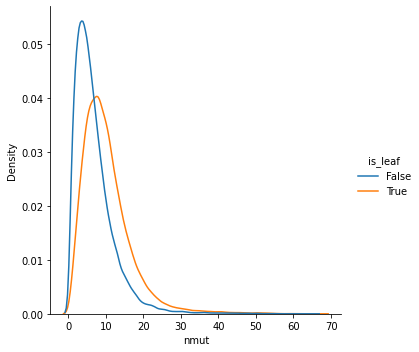

In [44]:
_d = mut.groupby(['is_leaf', 'child_node']).Pos.count()\
        .rename('nmut').reset_index()

sns.displot(data=_d, x='nmut', hue='is_leaf', kind='kde')
_d.groupby('is_leaf').nmut.describe()

In [45]:
# all contexts match
for cxt_i in [0,1,3,4]:
    assert (mut.parent_nucl_context.str.get(cxt_i) == mut.child_nucl_context.str.get(cxt_i)).all()

In [46]:
ref_annot = ref[['Pos', 'GenType', 'GenName', 'RefNuc', 'RefCxt', 'RefCodon', 'RefAa', 'NucInCodon']].drop_duplicates()
ref_annot['RefNuc'] = ref_annot['RefNuc'].str.replace('U', 'T')
ref_annot['RefCodon'] = ref_annot['RefCodon'].str.replace('U', 'T')
ref_annot['RefCxt'] = ref_annot['RefCxt'].str.replace('U', 'T')
ref_annot.sample(10)

,Pos,GenType,GenName,RefNuc,RefCxt,RefCodon,RefAa,NucInCodon
8839,2947,translated,ORF1ab,C,GCA,GGC,Gly,3
43090,14364,translated,ORF1ab,G,TGC,CTG,Leu_CU,3
9412,3138,translated,ORF1ab,A,AAA,AAA,Lys,2
19492,6498,translated,ORF1ab,A,AAA,AAA,Lys,2
86191,28731,translated,N,A,AAC,AAC,Asn,2
59473,19825,translated,ORF1ab,G,GGT,GTG,Val,1
22441,7481,translated,ORF1ab,T,TTC,TCA,Ser_UC,1
49201,16401,translated,ORF1ab,T,GTG,TGT,Cys,3
7336,2446,translated,ORF1ab,T,CTG,ACT,Thr,3
5323,1775,translated,ORF1ab,G,TGA,GAA,Glu,1


In [47]:
df = mut.merge(ref_annot, on=['Pos'])
df = df[df.is_leaf]
df = df[(df.GenType == 'translated') & (df.NucInCodon.isin(list('123')))]
df['NucInCodon'] = df['NucInCodon'].astype(int)
df['Codon'] = df.apply(lambda x: x.parent_nucl_context[3-x.NucInCodon: 6-x.NucInCodon], axis=1).str.upper()
df['AltCodon'] = df.apply(lambda x: x.child_nucl_context[3-x.NucInCodon: 6-x.NucInCodon], axis=1).str.upper()
df['ParentAa'] = df.Codon.apply(coda.translate_codon)
df['ChildAa']  = df.AltCodon.apply(coda.translate_codon)
df['is_syn'] = df.ParentAa == df.ChildAa
df['is_syn4f'] = df.Codon.apply(coda.is_fourfold)
df['MutType'] = df.is_syn.astype(int) + df.is_syn4f.astype(int)
df

,parent_nucl,child_nucl,parent_nucl_context,child_nucl_context,parent_node,child_node,Pos,is_leaf,Mut,Cxt,...,RefCodon,RefAa,NucInCodon,Codon,AltCodon,ParentAa,ChildAa,is_syn,is_syn4f,MutType
2,A,G,gtAtt,gtGtt,#8510#,hCoV-19/England/CAMC-DED2D9/2020,1087,True,T[A>G]T,TAT,...,GTA,Val,3,GTA,GTG,V,V,True,True,2
9,G,A,gtGtt,gtAtt,#51988#,hCoV-19/USA/CA-CDC-QDX26344066/2021,1087,True,T[G>A]T,TGT,...,GTA,Val,3,GTG,GTA,V,V,True,True,2
11,G,A,gtGtt,gtAtt,#33495#,hCoV-19/Canada/QC-1nIUH-5524145286/2020,1087,True,T[G>A]T,TGT,...,GTA,Val,3,GTG,GTA,V,V,True,True,2
12,G,A,gtGtt,gtAtt,#30119#,hCoV-19/Spain/MD-HLP-R68/2020,1087,True,T[G>A]T,TGT,...,GTA,Val,3,GTG,GTA,V,V,True,True,2
13,A,G,gtAtt,gtGtt,#51445#,hCoV-19/Russia/MOW-CRIE-D186B0085/2021,1087,True,T[A>G]T,TAT,...,GTA,Val,3,GTA,GTG,V,V,True,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925922,C,T,gtCgt,gtTgt,#1461#,hCoV-19/Brazil/AM-FIOCRUZ-21894423KCC/2021,7465,True,T[C>T]G,TCG,...,GTT,Val,3,GTC,GTT,V,V,True,True,2
925923,C,T,gtCgt,gtTgt,#1461#,hCoV-19/Brazil/AM-FIOCRUZ-21890578ACL/2021,7465,True,T[C>T]G,TCG,...,GTT,Val,3,GTC,GTT,V,V,True,True,2
925924,T,A,atTtc,atAtc,#26801#,hCoV-19/Brazil/RN-FIOCRUZ-46065/2021,11169,True,T[T>A]T,TTT,...,TTT,Phe,2,TTT,TAT,F,Y,False,False,0
925926,A,T,atAtc,atTtc,#1461#,hCoV-19/Brazil/AM-FIOCRUZ-21894423KCC/2021,11169,True,T[A>T]T,TAT,...,TTT,Phe,2,TAT,TTT,Y,F,False,False,0


In [48]:
df.groupby(['is_leaf']).MutType.value_counts(normalize=True).round(3).unstack()

MutType,0,1,2
is_leaf,,,
True,0.297,0.513,0.189


### save obs nums

In [49]:
obs_freqs = pd.concat([
        df.Mut.value_counts().rename('ObsMut_all'),
        df[df.is_syn].Mut.value_counts().rename('ObsMut_syn'),
        df[df.is_syn4f].Mut.value_counts().rename('ObsMut_syn4f'),
    ], axis=1,
)
obs_freqs.index.name = 'Mut'
obs_freqs.to_csv('../data/spectra_verification/observed_mutations_full_genome192leaves.csv')
obs_freqs

,ObsMut_all,ObsMut_syn,ObsMut_syn4f
Mut,,,
A[C>T]A,24877,14949.0,7757.0
A[T>C]A,24626,14865.0,NaN
A[C>T]T,20940,8473.0,14189.0
A[T>C]T,20643,8549.0,NaN
T[C>T]T,16773,9490.0,12658.0
...,...,...,...
G[G>C]C,24,7.0,24.0
G[C>G]G,24,6.0,24.0
G[G>C]G,23,6.0,23.0


In [50]:
obs_freqs['sbs12'] = obs_freqs.index.str.slice(2,5)
obs_freqs12 = obs_freqs.groupby('sbs12').sum().astype(int)
obs_freqs12.to_csv('../data/spectra_verification/observed_mutations_full_genome12leaves.csv')
obs_freqs12

,ObsMut_all,ObsMut_syn,ObsMut_syn4f
sbs12,,,
A>C,9762,1757,1945
A>G,46067,15542,10132
A>T,7499,3223,3168
C>A,9263,1695,6998
C>G,4493,518,2370
C>T,152411,81511,98125
G>A,49293,16269,28814
G>C,4405,495,1680
G>T,51506,9789,28475


In [51]:
dd2 = []
for g in long_genes.index:
    d = df[df.GenName == g]
    gobs_df = pd.concat([
        d.Mut.value_counts().rename('ObsMut_all'),
        d[d.is_syn].Mut.value_counts().rename('ObsMut_syn'),
        d[d.is_syn4f].Mut.value_counts().rename('ObsMut_syn4f'),
    ], axis=1)\
        .assign(Gene=g)
    gobs_df.index.name = 'Mut'
    dd2.append(gobs_df.reset_index().set_index(['Gene', 'Mut']))

genes_obs_df = pd.concat(dd2)
genes_obs_df.to_csv('../data/spectra_verification/observed_mutations_genes192leaves.csv')
genes_obs_df

ObsMut_all  ObsMut_syn  ObsMut_syn4f
Gene   Mut                                          
ORF1ab A[C>T]A       17871     11065.0        5539.0
       A[T>C]A       17711     11053.0           NaN
       A[C>T]T       13983      5876.0        9459.0
       A[T>C]T       13729      5864.0           NaN
       T[C>T]T       10328      6941.0        7154.0
...                    ...         ...           ...
ORF7a  T[G>C]C           1         NaN           NaN
       T[C>G]C           1         NaN           1.0
       G[T>G]G           1         NaN           NaN
       C[A>C]G           1         1.0           1.0
       G[A>T]T           1         NaN           NaN

[1281 rows x 3 columns]

### read freqs and calculate spectra tables

In [54]:
obs12 = pd.read_csv('../data/spectra_verification/observed_mutations_full_genome12leaves.csv')
exp12 = pd.read_csv('../data/spectra_verification/expexted_mutations_full_genome12.csv')
exp12['sbs12'] = exp12['sbs12'].str.replace('U', 'T')
ms12 = pd.merge(obs12, exp12, on='sbs12')
ms12.rename(columns={'sbs12':'Mut'}, inplace=True)
for mt in ['all', 'syn', 'syn4f']:
    ms12[f'MutSpec_{mt}'] = ms12[f'ObsMut_{mt}'] / ms12[f'ExpMut_{mt}']
    ms12[f'MutSpec_{mt}'] = ms12[f'MutSpec_{mt}'] / ms12[f'MutSpec_{mt}'].sum()
ms12.to_csv('../data/spectra_verification/spectra12leaves.csv', index=False)
ms12

,Mut,ObsMut_all,ObsMut_syn,ObsMut_syn4f,ExpMut_all,ExpMut_syn,ExpMut_syn4f,MutSpec_all,MutSpec_syn,MutSpec_syn4f
0,A>C,9762,1757,1945,8952,1590,1230,0.014293,0.007944,0.003871
1,A>G,46067,15542,10132,8952,2596,1230,0.067448,0.043039,0.020165
2,A>T,7499,3223,3168,8952,1387,1230,0.010979,0.016705,0.006305
3,C>A,9263,1695,6998,5492,704,609,0.022106,0.017309,0.028130
4,C>G,4493,518,2370,5492,582,582,0.010723,0.006398,0.009969
5,C>T,152411,81511,98125,5492,1670,731,0.363732,0.350885,0.328602
6,G>A,49293,16269,28814,5863,919,277,0.110195,0.127265,0.254643
7,G>C,4405,495,1680,5863,277,277,0.009847,0.012847,0.014847
8,G>T,51506,9789,28475,5863,277,277,0.115142,0.254053,0.251647
9,T>A,6793,2990,3842,9594,2421,2160,0.009280,0.008879,0.004354


In [55]:
obs192 = pd.read_csv('../data/spectra_verification/observed_mutations_full_genome192leaves.csv')
exp192 = pd.read_csv('../data/spectra_verification/expexted_mutations_full_genome192.csv')
exp192['Mut'] = exp192['Mut'].str.replace('U', 'T')
ms192 = pd.merge(obs192, exp192, on='Mut')
for mt in ['all', 'syn', 'syn4f']:
    ms192[f'MutSpec_{mt}'] = ms192[f'ObsMut_{mt}'] / ms192[f'ExpMut_{mt}']
    ms192[f'MutSpec_{mt}'] = ms192[f'MutSpec_{mt}'] / ms192[f'MutSpec_{mt}'].sum()
ms192.to_csv('../data/spectra_verification/spectra192leaves.csv', index=False)
ms192

,Mut,ObsMut_all,ObsMut_syn,ObsMut_syn4f,ExpMut_all,ExpMut_syn,ExpMut_syn4f,MutSpec_all,MutSpec_syn,MutSpec_syn4f
0,A[C>T]A,24877,14949.0,7757.0,809,269.0,NaN,0.023075,0.024469,NaN
1,A[T>C]A,24626,14865.0,NaN,471,240.0,NaN,0.039235,0.027272,NaN
2,A[C>T]T,20940,8473.0,14189.0,674,210.0,56.0,0.023314,0.017766,0.043177
3,A[T>C]T,20643,8549.0,NaN,773,393.0,NaN,0.020040,0.009578,NaN
4,T[C>T]T,16773,9490.0,12658.0,542,185.0,104.0,0.023223,0.022587,0.020741
...,...,...,...,...,...,...,...,...,...,...
187,G[G>C]C,24,7.0,24.0,223,8.0,8.0,0.000081,0.000385,0.000511
188,G[C>G]G,24,6.0,24.0,88,21.0,21.0,0.000205,0.000126,0.000195
189,G[G>C]G,23,6.0,23.0,134,10.0,10.0,0.000129,0.000264,0.000392
190,C[C>G]G,22,15.0,22.0,74,27.0,27.0,0.000223,0.000245,0.000139


### plot spectra

In [64]:
ms12 = pd.read_csv('../data/spectra_verification/spectra12.csv')
ms192 = pd.read_csv('../data/spectra_verification/spectra192.csv')

In [57]:
from pymutspec.draw.spectra import colors12, sbs12_ordered

sbs12tocolor = dict(zip(sbs12_ordered, colors12))

sbs12_ordered_my = sorted(sbs12_ordered)
colors12_my = [sbs12tocolor[x] for x in sbs12_ordered_my]

def plot_mutspec12_custom(
        mutspec: pd.DataFrame, 
        spectra_col="MutSpec", 
        title="Full mutational spectrum", 
        ylabel=None, 
        figsize=(6, 4), 
        style="bar", 
        savepath=None, 
        fontname="Times New Roman",
        ticksize=8,
        titlesize=14,
        ylabelsize=12,
        show=True, 
        **kwargs,
    ):
    # TODO add checks of mutspec12
    # TODO add description to all plot* functions
    if style == "bar":
        plot_func = sns.barplot
    elif style == "box":
        plot_func = sns.boxplot
    else:
        raise NotImplementedError

    fig = plt.figure(figsize=figsize)
    ax = plot_func(x="Mut", y=spectra_col, data=mutspec, order=sbs12_ordered_my, ax=fig.gca(), **kwargs)
    ax.grid(axis="y", alpha=.7, linewidth=0.5)

    # map colors to bars
    for bar, clr in zip(ax.patches, colors12_my):
        bar.set_color(clr)

    ax.set_title(title, fontsize=titlesize, fontname=fontname)
    ax.set_ylabel(ylabel if ylabel else "", fontsize=ylabelsize, fontname=fontname)
    ax.set_xlabel("")

    plt.xticks(fontsize=ticksize, fontname=fontname)

    if savepath is not None:
        plt.savefig(savepath)
    if show:
        plt.show()
    else:
        plt.close()
    return ax

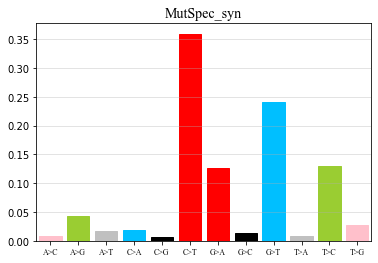

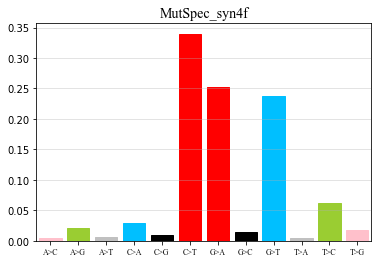

In [66]:
ms12 = pd.read_csv('../data/spectra_verification/spectra12.csv')
for mt in ['syn', 'syn4f']:
    plot_mutspec12_custom(ms12, f'MutSpec_{mt}', f'MutSpec_{mt}')

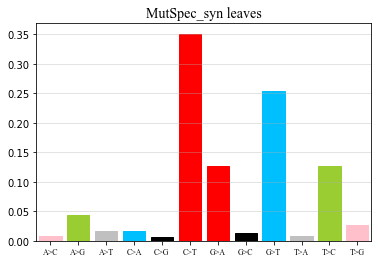

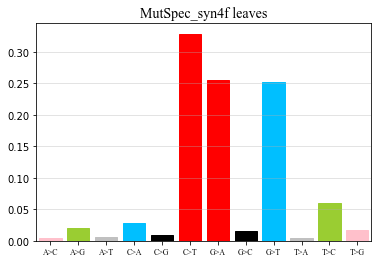

In [67]:
ms12 = pd.read_csv('../data/spectra_verification/spectra12leaves.csv')
for mt in ['syn', 'syn4f']:
    plot_mutspec12_custom(ms12, f'MutSpec_{mt}', f'MutSpec_{mt} leaves')

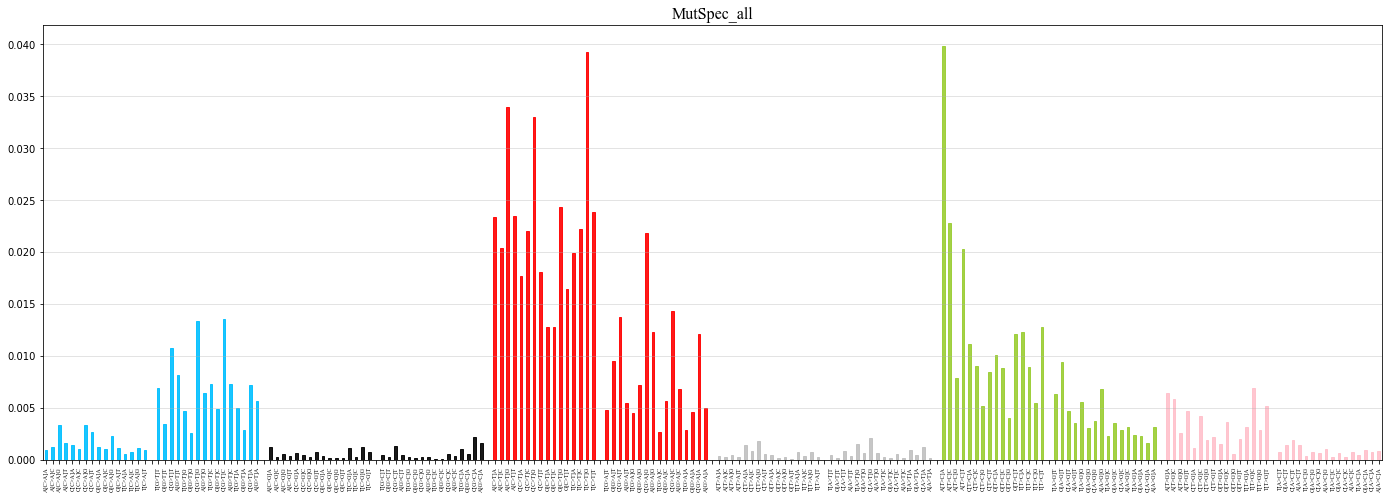

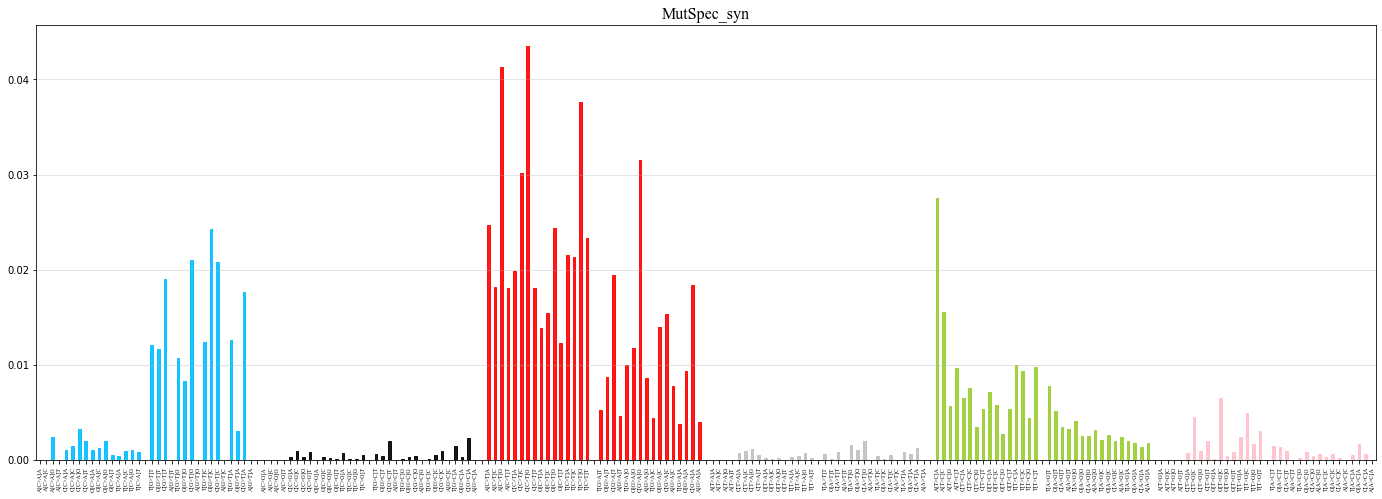

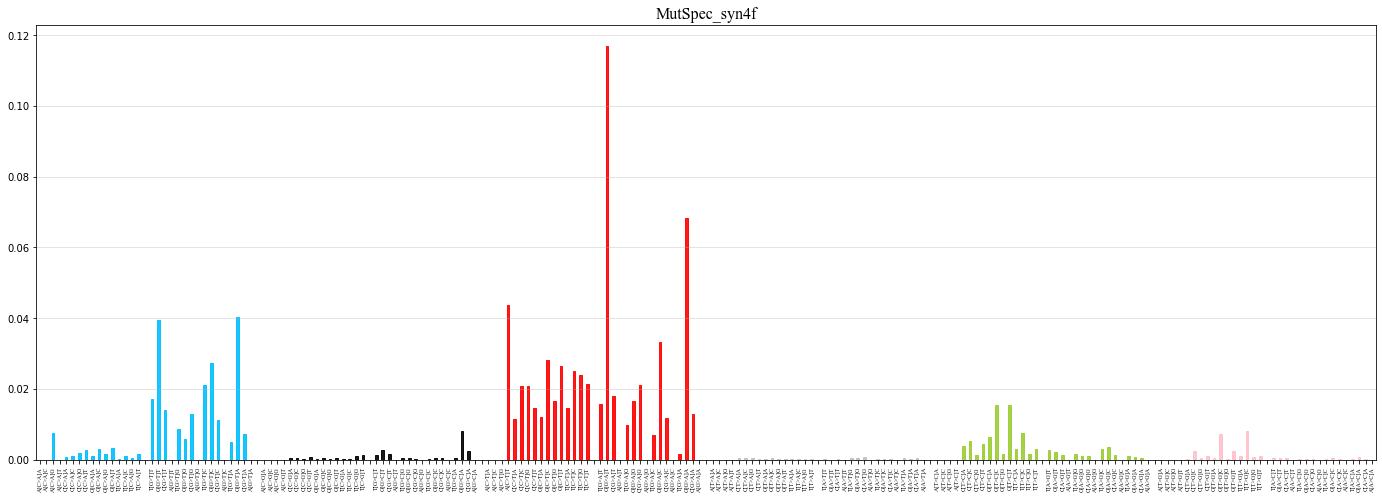

In [221]:
for mt in ['all', 'syn', 'syn4f']:
    plot_mutspec192(ms192, f'MutSpec_{mt}', f'MutSpec_{mt}')